In [35]:
import os
import json
import random
import pickle
import cv2
import numpy as np
import pandas as pd
import skimage as sk
import functions as ff
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as T
from tqdm import tqdm
from PIL import Image, ImageDraw, ImageChops
from pathlib import Path
from sklearn import svm
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score,confusion_matrix,ConfusionMatrixDisplay

In [36]:
def load_image(image,transform):
  new_img, _ = ff.pad_image(image)
  new_img = transform(new_img)[:3].unsqueeze(0)
  return new_img

def compute_embeddings(image_paths,device,transform,transformer):
  all_embeddings = {}
  with torch.no_grad():
    for _, img in enumerate(tqdm(image_paths,desc="Processing files")):
      embeddings = transformer(load_image(img,transform).to(device))
      all_embeddings[img] = np.array(embeddings[0].cpu().numpy()).reshape(1, -1).tolist()

  with open("all_embeddings.json", "w") as f:
      f.write(json.dumps(all_embeddings))
  
  return all_embeddings

def test_model(images,img_lbl_dict,embeddings,classes,model):
  images_embeddings = ff.get_values(images,embeddings)
  embeddings_list = np.array(list(images_embeddings)).reshape(-1,384)
  with torch.no_grad():
    predictions = model.predict(embeddings_list)
    labels = ff.get_values(images,img_lbl_dict)
    res = ff.calculate_metrics(labels,predictions)
    print(f"Accuracy: {res[0]}, Precision: {res[1]}, Recall: {res[2]}, F1 score: {res[3]}")
    ff.create_cm(labels,predictions,classes)


In [49]:
furkan_images_dir = "./dataset/Furkan_Pan/images"
gamze_images_dir = "./dataset/Gamze_Pan/images"
furkan_excel_path = "./dataset/Furkan_Excel.xlsx"
gamze_excel_path = "./dataset/Gamze_Excel.xlsx"
total_excel_path = "./dataset/Total_Excel.xlsx"
furkan_json_dir = "./dataset/Furkan_Pan/JSON/outputs"
gamze_json_dir = "./dataset/Gamze_Pan/JSON/outputs"
masks_dir = "./masks"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
transform = T.Compose([T.ToTensor(),T.Normalize([0.5], [0.5])])
classes = ["Hatasız","Hatalı"]

In [62]:
labels_file = pd.read_excel(total_excel_path,header=None,keep_default_na=False)
total_images_paths = ff.merge_directories(furkan_images_dir,gamze_images_dir,sort=True,fullPath=True)
total_json_paths = ff.merge_directories(furkan_json_dir,gamze_json_dir,isImage=False,sort=True,fullPath=True)
total_masks_paths = ff.create_list(masks_dir,sort=True,fullPath=True)
img_lbl_dict = ff.create_img_label_dict(total_images_paths,labels_file,column_num=1)
mask_img_dict = ff.create_dict(total_masks_paths,total_images_paths)
mask_lbl_dict = ff.create_img_label_dict(total_masks_paths,labels_file,column_num=1)
img_json_dict = ff.create_dict(total_images_paths,total_json_paths)
pd.Series({
    "Labels file length =" : len(labels_file),
    "Images list length =" : len(total_images_paths),
    "Masks list length =" : len(total_masks_paths),
    "Total json list length =" : len(total_json_paths),
    "Json dictionary length =" : len(img_json_dict),
    "Label dictionary  length =" : len(img_lbl_dict),
    "Label dictionary  length =" : len(mask_lbl_dict)
}).to_frame().style.hide(axis='columns')

In [53]:
masks_paths = random.sample(total_masks_paths,1400)         ## Get 1400 sample randomly for training.
print(f"For train: {len(masks_paths)}, Total: {len(total_masks_paths)}")

For train: 1400, Total: 1497


In [55]:
#print(f"Repeated Elements: {findRepeatedElements(images_paths)}")
test_masks = ff.getNotFoundElements(total_masks_paths,masks_paths)
print(f"Test images: {len(test_masks)}")

Test images: 97


In [59]:
ff.display_images_labels(masks_paths,mask_lbl_dict)

Image  Label
0      ./masks\227.png      1
1      ./masks\175.png      0
2      ./masks\640.png      0
3     ./masks\2635.png      1
4     ./masks\2282.png      0
...                ...    ...
1395    ./masks\54.png      1
1396  ./masks\2574.png      0
1397  ./masks\2879.png      0
1398    ./masks\33.png      0
1399  ./masks\2622.png      0

[1400 rows x 2 columns]

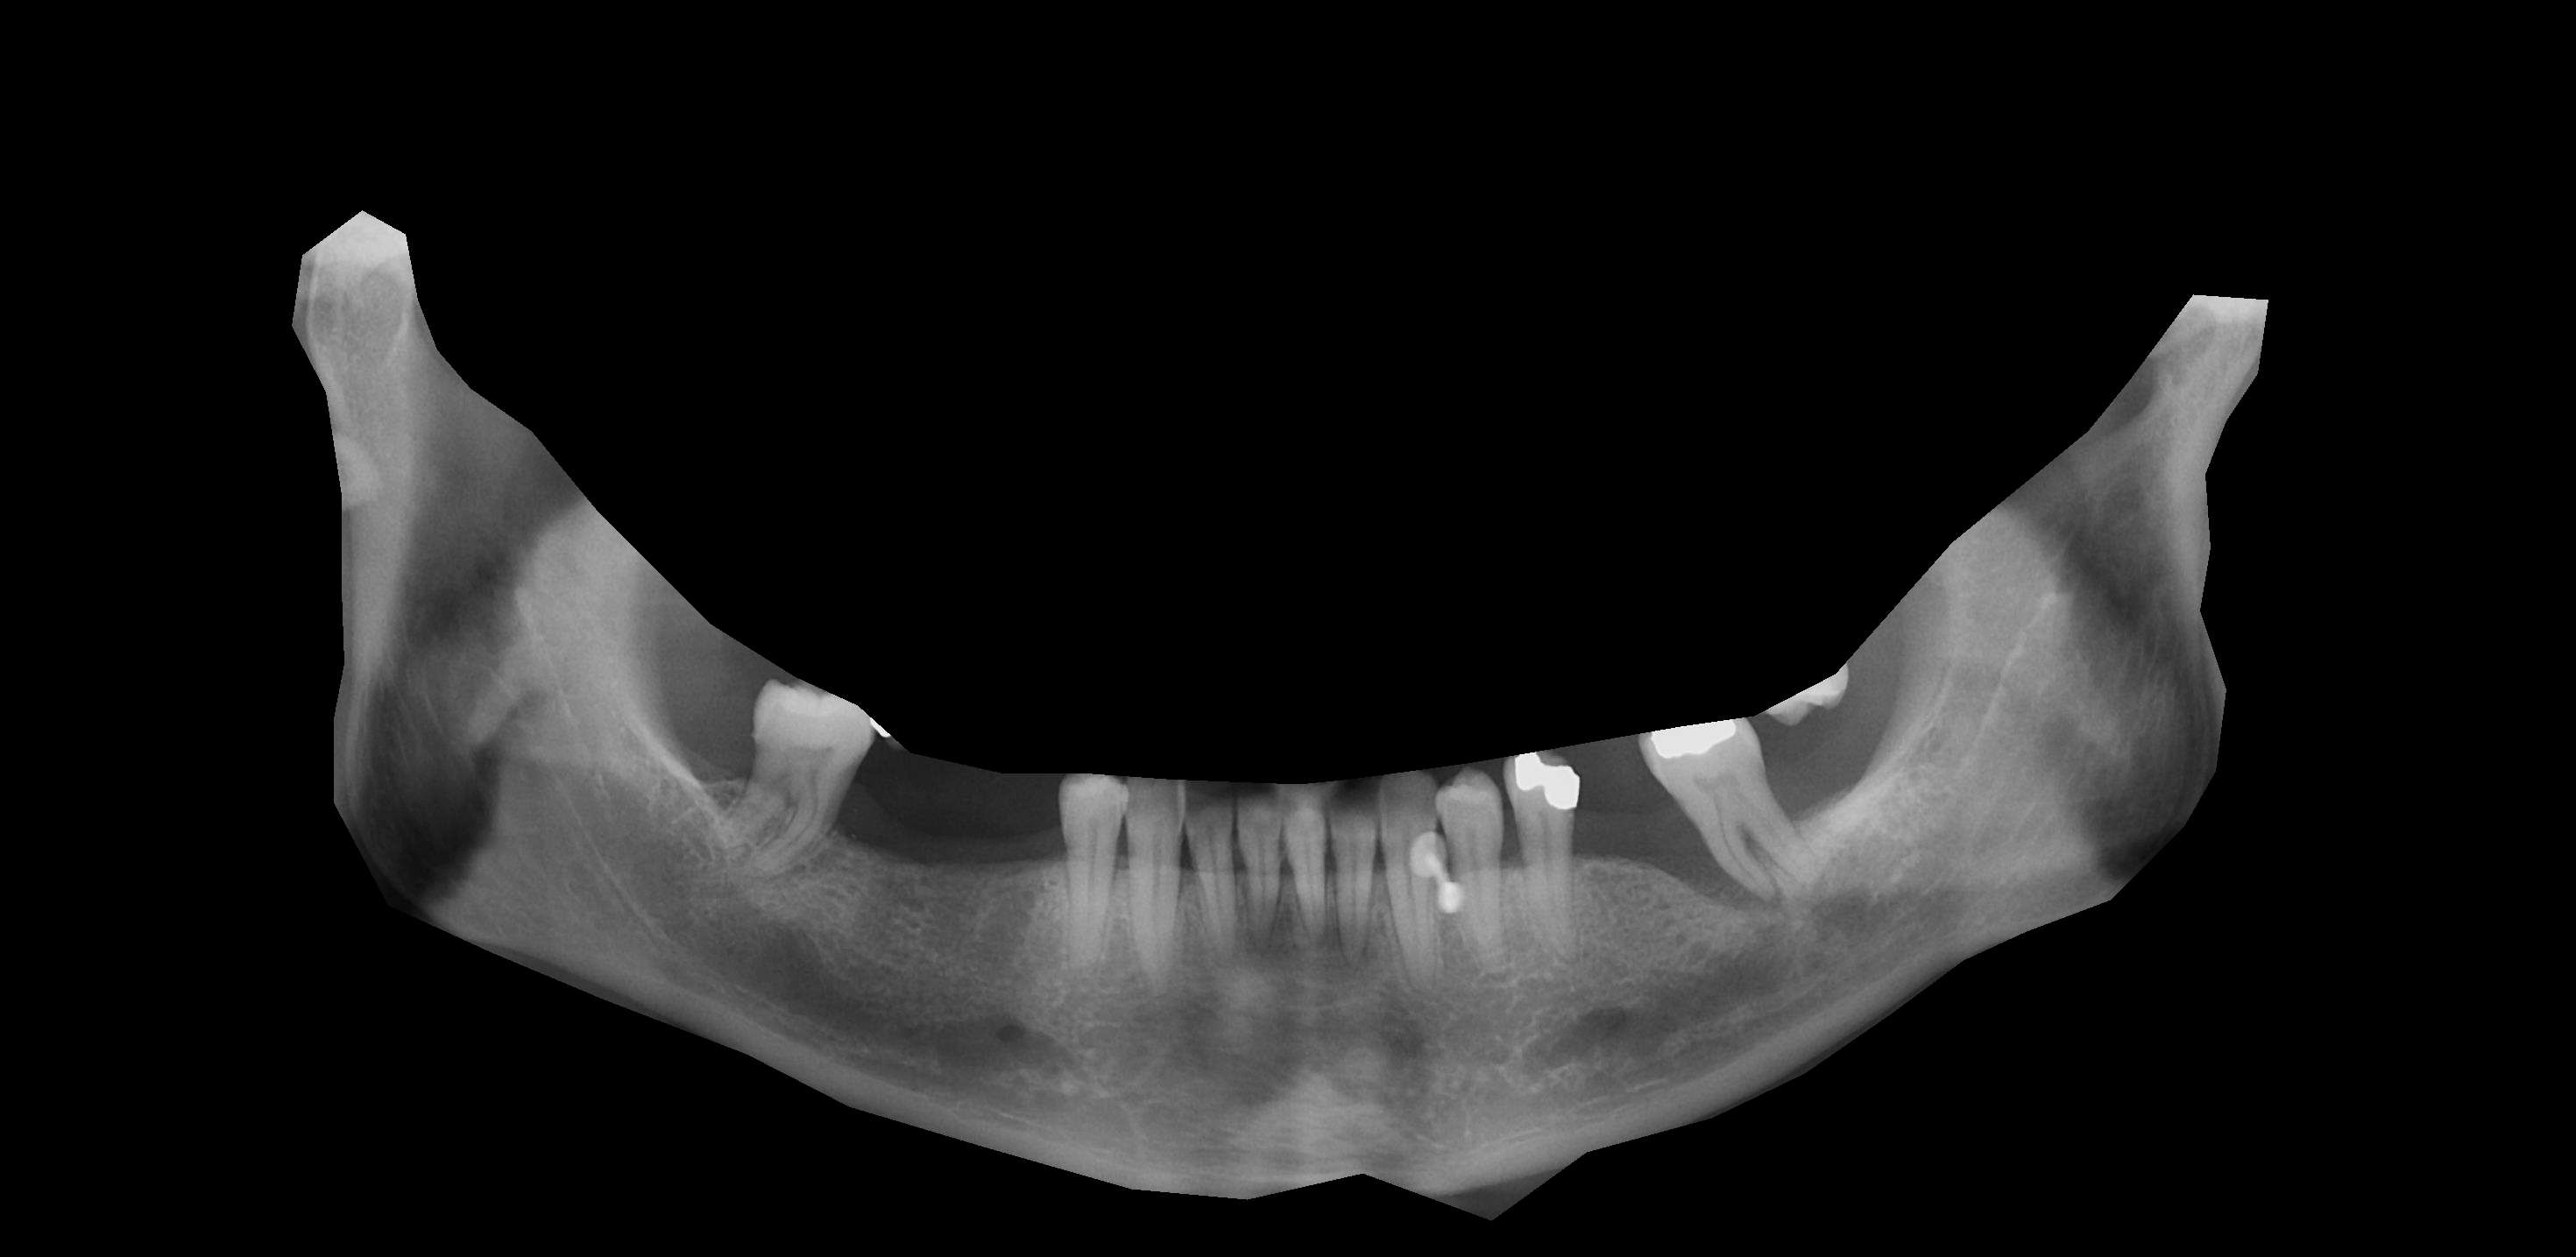

In [61]:
sample = random.choice(total_masks_paths)
img_s = Image.open(sample).convert('RGB')
img_s

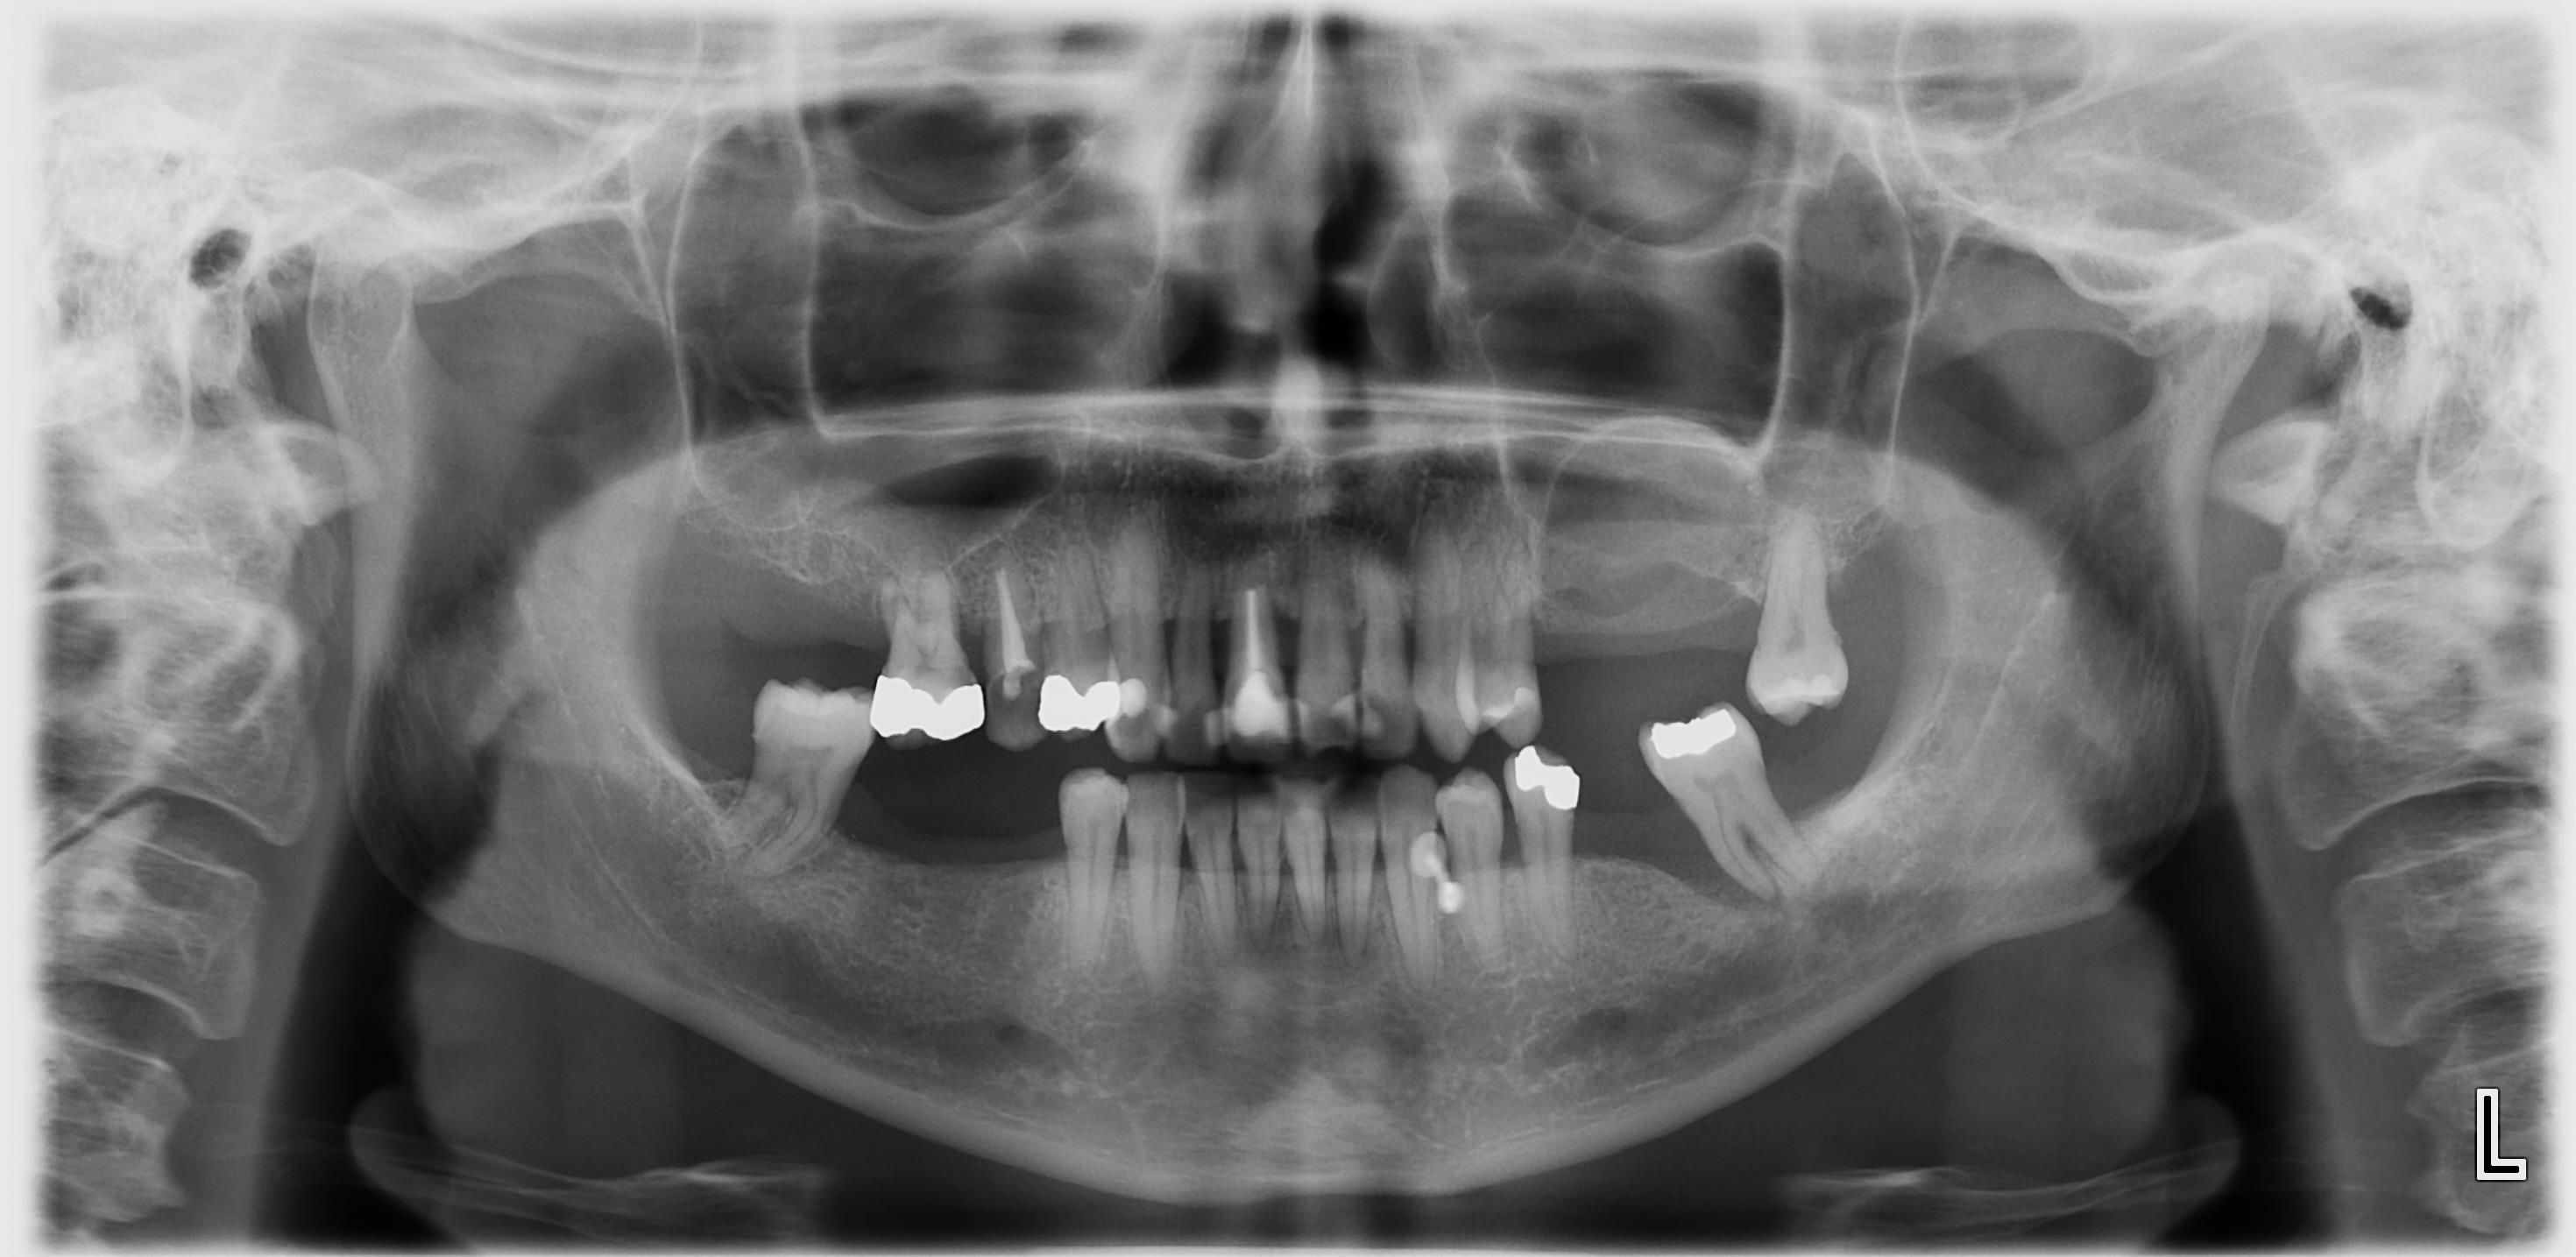

In [63]:
sample_img_path = mask_img_dict[sample]
sample_img = Image.open(sample_img_path).convert('RGB')
sample_img

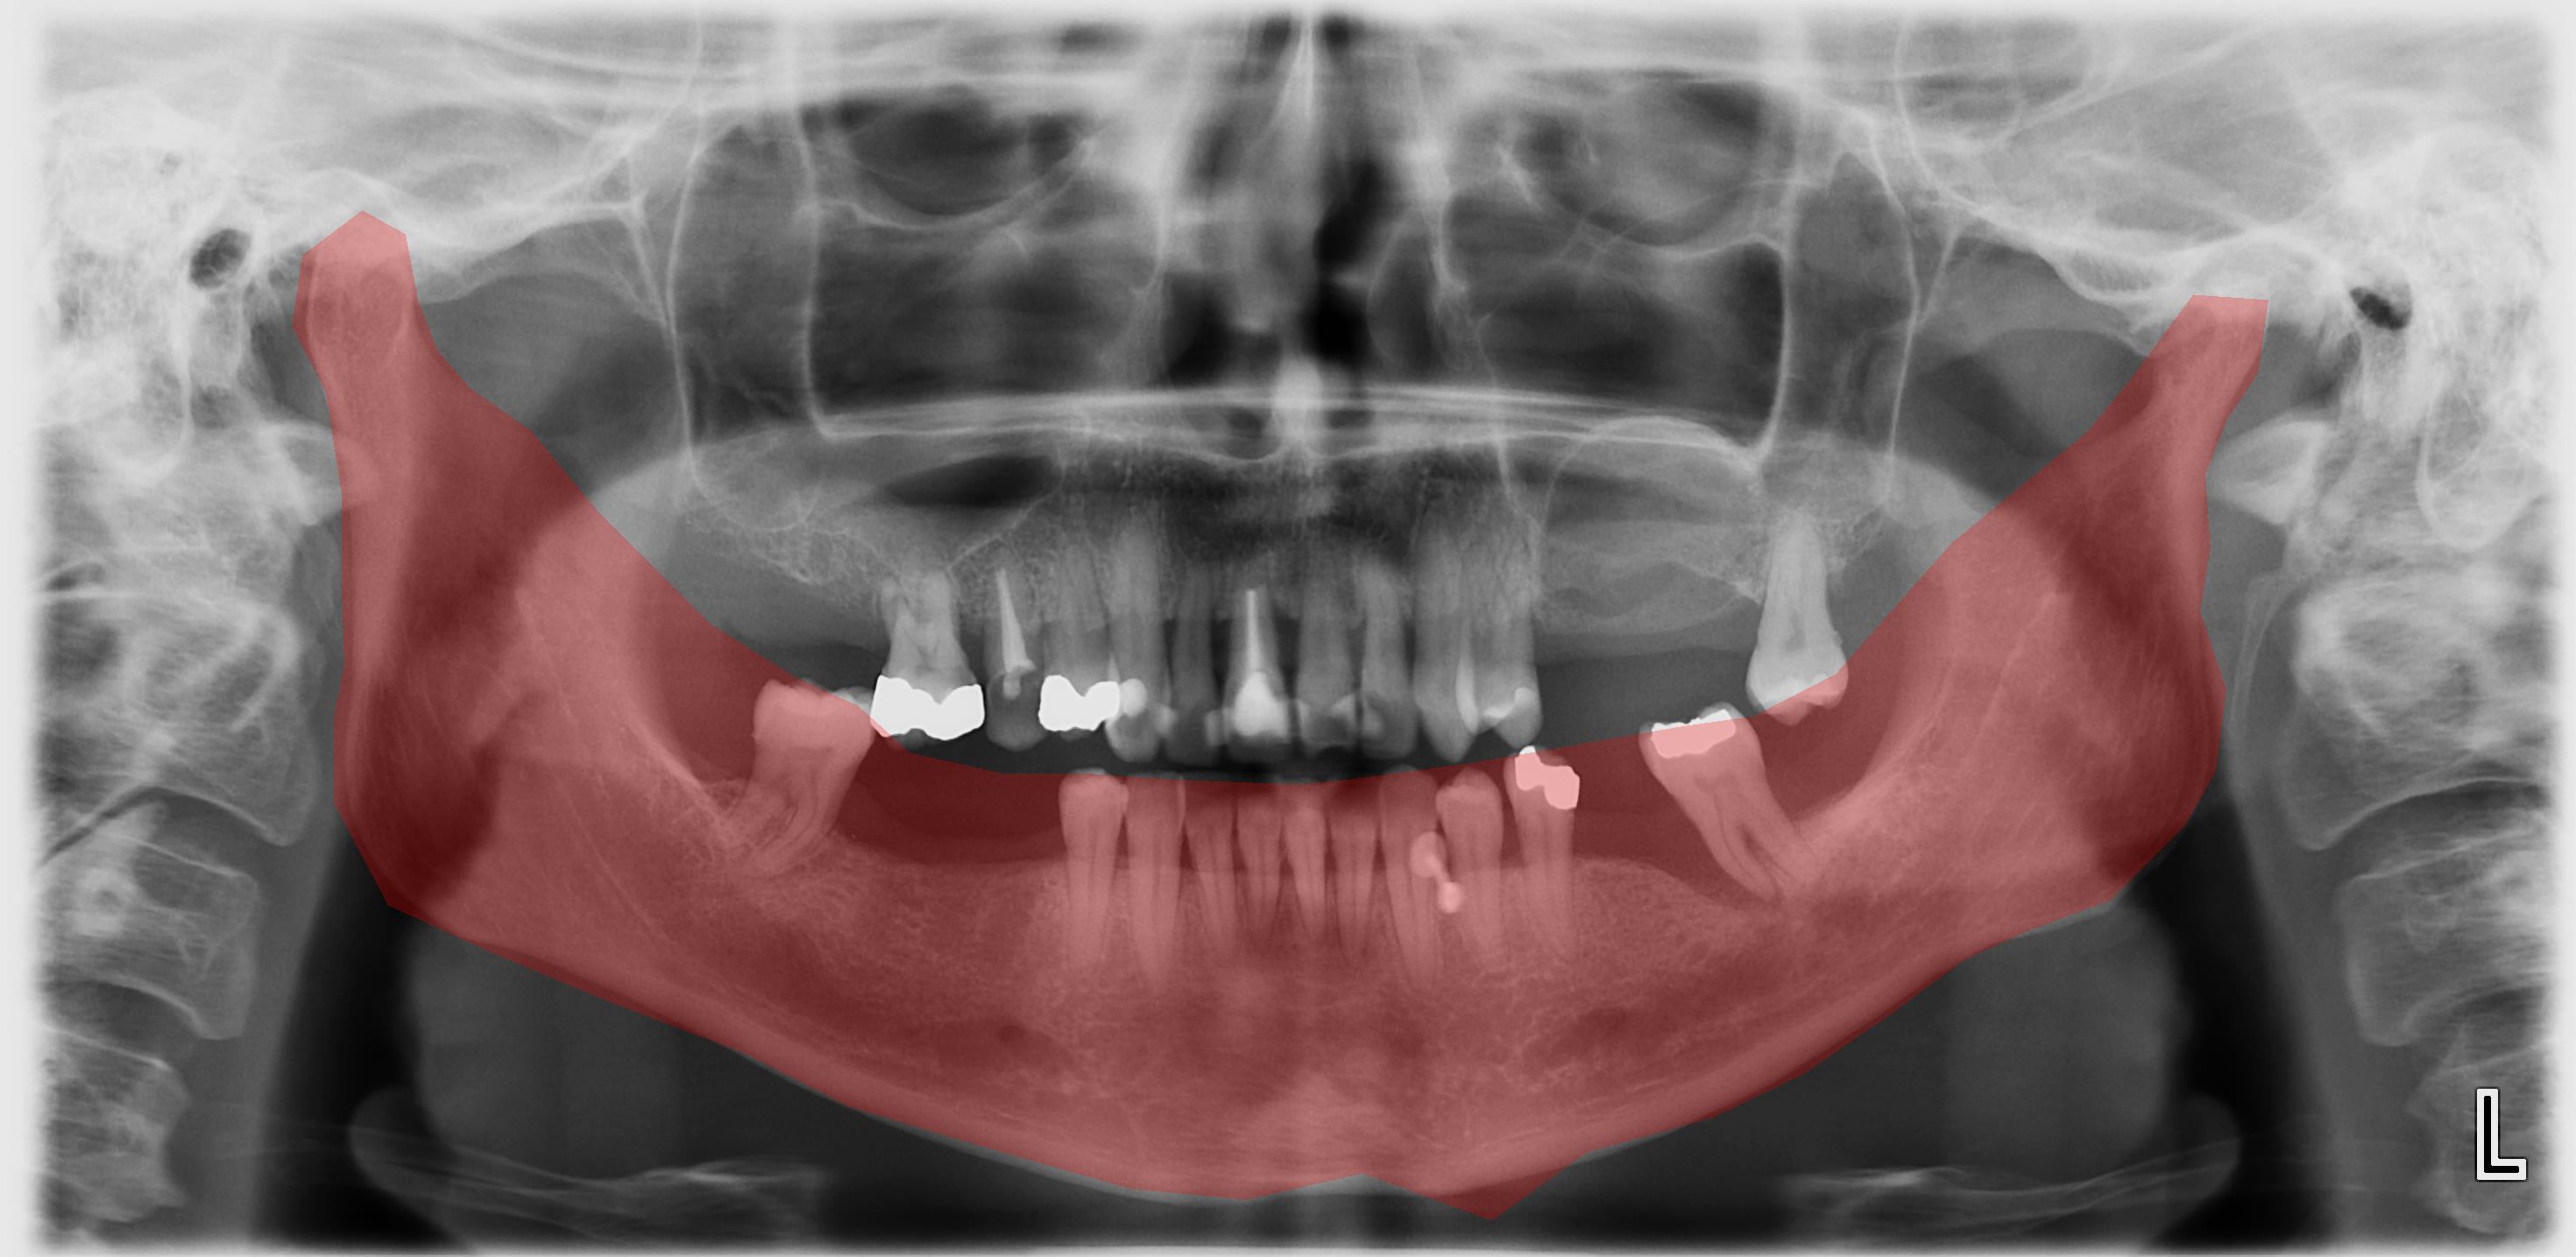

In [64]:
sample_json_path = img_json_dict[sample_img_path]
masked_image = ff.draw_overlay_mask_on_org_image(sample_img_path,sample_json_path)
masked_image

In [66]:
ff.extract_mask(sample_img_path,sample_json_path)

AttributeError: module 'functions' has no attribute 'extract_mask'

In [47]:
total_masks = ff.extract_all_masks(total_images_paths,img_json_dict)

100%|██████████| 1497/1497 [08:25<00:00,  2.96it/s]


In [ ]:
total_masks = []
loop = tqdm(total_images_paths)
for i,file in enumerate(loop):
    image = Image.open(file).convert('RGB')
    image_arr = np.array(image,dtype=np.uint8)
    json_p = img_json_dict[file]
    mask = ff.draw_mask_with_imageDraw(file,json_p)
    mm = np.array(mask)
    maske = cv2.bitwise_and(image_arr,image_arr,mask=mm)
    
    total_masks.append(maske)

In [ ]:
img_mask_dict = ff.create_dict(total_images_paths,total_masks)
len(img_mask_dict)

In [ ]:
sample_path = random.choice(total_images_paths)
sample_img = Image.open(sample_path)
sample_img

In [ ]:
sample_mask = img_mask_dict[sample_path]
mask = Image.fromarray(sample_mask)
mask

In [ ]:
ff.draw_overlay_mask_on_org_image(sample_path,img_json_dict[sample_path])

## Hangi resize işlemi kullanayım diye bu iki scripti çalıştırıyorum.


In [ ]:
path = random.choice(total_images_paths)
sample = Image.open(path).convert('RGB')
sample

In [ ]:
transformed = T.Resize((350,350))(sample)
transformed

In [ ]:
img, info = pad_image(path)
print(info)
img

## Training

In [ ]:
dinov2_vits14 = torch.hub.load('facebookresearch/dinov2', 'dinov2_vits14')
dinov2_vits14 = dinov2_vits14.to(device)

In [ ]:
clf = svm.SVC(probability=True,gamma='scale')               ## Initialize classifier
K = 5                                                       ## Number of folds
kf = KFold(n_splits=K)                                      ## Define K-Fold method for cross validation

In [ ]:
total_embeddings = compute_embeddings(total_images_paths,device,transform,dinov2_vits14)

In [ ]:
## Train loop
metrics = []
predicted = []
actual_lbls = []
model = None
for i, (train_index, test_index) in enumerate(kf.split(images_paths)):
  print(f"Fold {i+1}/{K}")
  ## Get select images for train/test folds.
  x_train = get_selected_indexes(train_index,images_paths)
  x_test  = get_selected_indexes(test_index,images_paths)

  train_emb = get_values(x_train,total_embeddings)
  test_emb = get_values(x_test,total_embeddings)

  train_emb_list = np.array(list(train_emb)).reshape(-1,384)
  test_emb_list = np.array(list(test_emb)).reshape(-1,384)
  ## Get corresponding labels.
  y_train = get_values(x_train,img_lbl_dict)
  y_test = get_values(x_test,img_lbl_dict)

  model = clf.fit(train_emb_list,y_train)
  predictions = model.predict(test_emb_list)
  
  predicted.extend(predictions)
  actual_lbls.extend(y_test)
  res = calculate_metrics(y_test,predictions)
  print(f"Accuracy: {res[0]}, Precision: {res[1]}, Recall: {res[2]}, F1 Score: {res[3]}")
  metrics.append(res)

create_cm(actual_lbls,predicted,classes)          ## Draw confusion matrix

In [ ]:
## Save the model
with open('./dinv2_vit14_model_with_svm.pth', 'wb') as model_file:
    pickle.dump(model, model_file)

## Training sonucunda modelin performansı gösterme

In [ ]:
avg_acc, avg_precision, avg_recall, avg_f1= 0, 0, 0, 0
acc = []
for i in range(K):
    avg_acc += metrics[i][0]
    acc.append(metrics[i][0])
    avg_precision += metrics[i][1]
    avg_recall += metrics[i][2]
    avg_f1 += metrics[i][3]

avg_acc = 100*avg_acc/K
avg_precision = 100*avg_precision/K
avg_recall = 100*avg_recall/K
avg_f1 = 100*avg_f1/K

pd.Series({
    "Average Accuracy" : avg_acc,
    "Average Precision": avg_precision,
    "Average Recall" : avg_recall,
    "Average F1 Score" : avg_f1
}).to_frame().style.hide(axis='columns')


In [ ]:
plt.plot(range(1,K+1),acc,color="blue",linewidth = 2,marker='o', markerfacecolor='red', markersize=8)
plt.title("Accuracy")
plt.xlabel("Fold")
plt.ylabel("Accuracy")
plt.show()

## Sadece 97 resim üzerinde test yapar.
Bu resimler training aşamasına dahil edilmedi.

In [ ]:
test_model(test_images,img_lbl_dict,total_embeddings,classes,model)

## Bütün resimler için test

In [ ]:
test_model(total_images_paths,img_lbl_dict,total_embeddings,classes,model)